In [1]:
import os

In [2]:
DATA_PATH = '/lfs/1/danfu/rekall_experiments/parking_space_experiments/user_study'

In [3]:
with open(os.path.join(DATA_PATH, 'dev.txt'), 'r') as f:
    dev_videos = list(l.strip() for l in f.readlines())
with open(os.path.join(DATA_PATH, 'test.txt'), 'r') as f:
    test_videos = list(l.strip() for l in f.readlines())

In [4]:
print(dev_videos)
print(test_videos)

['video1', 'video3']
['video2', 'video4']


# Define data loaders

In [5]:
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import pickle

class ParkingSpaceDataset(torch.utils.data.Dataset):
    def __init__(self, root, video_list, transforms=None, 
                 include_cars=False, non_empty_images_only=True):
        self.root = root
        self.include_cars = include_cars
        self.non_empty_images_only = non_empty_images_only
        
        image_folder = os.path.join(root, 'images_ffmpeg')
        gt_folder = os.path.join(root, 'empty_spaces')
        object_folder = os.path.join(root, 'bboxes')
        
        self.transforms = transforms
        
        image_list = []
        bbox_list = []
        other_object_list = []
        for video in video_list:
            images = os.path.join(image_folder, video)
            gt_bbox_folder = os.path.join(gt_folder, video)
            other_object_folder = os.path.join(object_folder, video)
            
            image_paths = list(sorted(os.listdir(images)))
            with open(os.path.join(gt_bbox_folder, 'gt.pkl'), 'rb') as f:
                bboxes = pickle.load(f)
            with open(os.path.join(other_object_folder, 'bboxes.pkl'), 'rb') as f:
                other_objects = pickle.load(f)
                
            for img, bbox, other_obj in zip(image_paths, bboxes, other_objects):
                if non_empty_images_only:
                    if include_cars and len(bbox) + len(other_obj) == 0:
                        continue
                    if not include_cars and len(bbox) == 0:
                        continue
                image_list.append(os.path.join(images, img))
                bbox_list.append(bbox)
                other_object_list.append(other_obj)
        
        self.imgs = image_list
        self.bboxes = bbox_list
        self.other_objects = other_object_list
        
    def __getitem__(self, idx):
        # load images
        img_path = self.imgs[idx]
        bboxes = self.bboxes[idx]
        other_objects = self.other_objects[idx]
        img = Image.open(img_path).convert('RGB')
        
        if self.include_cars:
            boxes_raw = bboxes + [
                o for o in other_objects if o[4] == 'car'
            ]
        else:
            boxes_raw = bboxes
        
        boxes = torch.as_tensor([
            box[:4]
            for box in boxes_raw
        ], dtype=torch.float32)
        
        if self.include_cars:
            labels = torch.cat((
                torch.ones((len(bboxes),), dtype=torch.int64),
                torch.ones((len(boxes_raw) - len(bboxes),), dtype=torch.int64) * 2
            ))
        else:
            labels = torch.ones((len(bboxes),), dtype=torch.int64)

        image_id = torch.tensor([idx])
        if len(boxes_raw) == 0:
            area = torch.tensor([])
        else:
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes_raw),), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = image_id
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
            
        return img, target
    
    def __len__(self):
        return len(self.imgs)

In [6]:
dataset = ParkingSpaceDataset(DATA_PATH, dev_videos)

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_bbox_model(num_classes):
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # replace the classifier with a new one, that has
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    
    return model

In [8]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [9]:
dataset = ParkingSpaceDataset(DATA_PATH, dev_videos, get_transform(train=True))
dataset_test = ParkingSpaceDataset(DATA_PATH, test_videos, get_transform(train=False))

In [10]:
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn, pin_memory=True)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=4, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn, pin_memory=True)

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [12]:
# our dataset has three classes only - background, parking space, and person
num_classes = 2

# get the model using our helper function
model = get_bbox_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [13]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/701]  eta: 0:34:17  lr: 0.000012  loss: 0.8076 (0.8076)  loss_classifier: 0.6621 (0.6621)  loss_box_reg: 0.0230 (0.0230)  loss_objectness: 0.1090 (0.1090)  loss_rpn_box_reg: 0.0135 (0.0135)  time: 2.9348  data: 0.8720  max mem: 6604
Epoch: [0]  [ 10/701]  eta: 0:09:56  lr: 0.000083  loss: 0.8071 (0.7991)  loss_classifier: 0.6310 (0.6038)  loss_box_reg: 0.0227 (0.0248)  loss_objectness: 0.1193 (0.1505)  loss_rpn_box_reg: 0.0191 (0.0200)  time: 0.8635  data: 0.0795  max mem: 7706
Epoch: [0]  [ 20/701]  eta: 0:08:40  lr: 0.000155  loss: 0.6305 (0.6293)  loss_classifier: 0.4135 (0.4397)  loss_box_reg: 0.0344 (0.0349)  loss_objectness: 0.1282 (0.1342)  loss_rpn_box_reg: 0.0196 (0.0205)  time: 0.6562  data: 0.0002  max mem: 7708
Epoch: [0]  [ 30/701]  eta: 0:08:08  lr: 0.000226  loss: 0.3829 (0.5562)  loss_classifier: 0.2095 (0.3688)  loss_box_reg: 0.0631 (0.0601)  loss_objectness: 0.0685 (0.1087)  loss_rpn_box_reg: 0.0145 (0.0186)  time: 0.6528  data: 0.0002  max mem: 7710


Epoch: [0]  [330/701]  eta: 0:04:06  lr: 0.002367  loss: 0.0232 (0.2024)  loss_classifier: 0.0160 (0.1033)  loss_box_reg: 0.0064 (0.0795)  loss_objectness: 0.0000 (0.0139)  loss_rpn_box_reg: 0.0012 (0.0056)  time: 0.6589  data: 0.0003  max mem: 7713
Epoch: [0]  [340/701]  eta: 0:03:59  lr: 0.002438  loss: 0.0262 (0.1973)  loss_classifier: 0.0177 (0.1009)  loss_box_reg: 0.0071 (0.0774)  loss_objectness: 0.0000 (0.0135)  loss_rpn_box_reg: 0.0013 (0.0055)  time: 0.6608  data: 0.0004  max mem: 7713
Epoch: [0]  [350/701]  eta: 0:03:52  lr: 0.002510  loss: 0.0274 (0.1924)  loss_classifier: 0.0178 (0.0985)  loss_box_reg: 0.0074 (0.0754)  loss_objectness: 0.0000 (0.0131)  loss_rpn_box_reg: 0.0015 (0.0054)  time: 0.6584  data: 0.0003  max mem: 7713
Epoch: [0]  [360/701]  eta: 0:03:46  lr: 0.002581  loss: 0.0230 (0.1877)  loss_classifier: 0.0159 (0.0962)  loss_box_reg: 0.0060 (0.0735)  loss_objectness: 0.0000 (0.0128)  loss_rpn_box_reg: 0.0012 (0.0053)  time: 0.6563  data: 0.0003  max mem: 7713


Epoch: [0]  [660/701]  eta: 0:00:27  lr: 0.004722  loss: 0.0172 (0.1128)  loss_classifier: 0.0118 (0.0596)  loss_box_reg: 0.0036 (0.0425)  loss_objectness: 0.0000 (0.0070)  loss_rpn_box_reg: 0.0011 (0.0037)  time: 0.6570  data: 0.0003  max mem: 7713
Epoch: [0]  [670/701]  eta: 0:00:20  lr: 0.004793  loss: 0.0172 (0.1113)  loss_classifier: 0.0114 (0.0588)  loss_box_reg: 0.0036 (0.0419)  loss_objectness: 0.0000 (0.0069)  loss_rpn_box_reg: 0.0012 (0.0036)  time: 0.6558  data: 0.0003  max mem: 7713
Epoch: [0]  [680/701]  eta: 0:00:13  lr: 0.004864  loss: 0.0158 (0.1100)  loss_classifier: 0.0102 (0.0581)  loss_box_reg: 0.0032 (0.0414)  loss_objectness: 0.0000 (0.0068)  loss_rpn_box_reg: 0.0014 (0.0036)  time: 0.6544  data: 0.0003  max mem: 7713
Epoch: [0]  [690/701]  eta: 0:00:07  lr: 0.004936  loss: 0.0172 (0.1087)  loss_classifier: 0.0119 (0.0575)  loss_box_reg: 0.0032 (0.0408)  loss_objectness: 0.0000 (0.0067)  loss_rpn_box_reg: 0.0014 (0.0036)  time: 0.6547  data: 0.0003  max mem: 7713


Epoch: [1]  [190/701]  eta: 0:05:38  lr: 0.005000  loss: 0.0148 (0.0170)  loss_classifier: 0.0097 (0.0119)  loss_box_reg: 0.0025 (0.0037)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0014 (0.0014)  time: 0.6532  data: 0.0002  max mem: 7713
Epoch: [1]  [200/701]  eta: 0:05:31  lr: 0.005000  loss: 0.0141 (0.0168)  loss_classifier: 0.0090 (0.0117)  loss_box_reg: 0.0025 (0.0036)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0013 (0.0014)  time: 0.6545  data: 0.0002  max mem: 7713
Epoch: [1]  [210/701]  eta: 0:05:24  lr: 0.005000  loss: 0.0133 (0.0167)  loss_classifier: 0.0092 (0.0117)  loss_box_reg: 0.0025 (0.0036)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0008 (0.0014)  time: 0.6557  data: 0.0003  max mem: 7713
Epoch: [1]  [220/701]  eta: 0:05:18  lr: 0.005000  loss: 0.0126 (0.0166)  loss_classifier: 0.0091 (0.0116)  loss_box_reg: 0.0025 (0.0035)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0007 (0.0014)  time: 0.6625  data: 0.0002  max mem: 7713


Epoch: [1]  [520/701]  eta: 0:01:59  lr: 0.005000  loss: 0.0101 (0.0142)  loss_classifier: 0.0067 (0.0100)  loss_box_reg: 0.0024 (0.0029)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0009 (0.0012)  time: 0.6589  data: 0.0002  max mem: 7713
Epoch: [1]  [530/701]  eta: 0:01:52  lr: 0.005000  loss: 0.0112 (0.0141)  loss_classifier: 0.0072 (0.0100)  loss_box_reg: 0.0024 (0.0029)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0008 (0.0012)  time: 0.6545  data: 0.0003  max mem: 7713
Epoch: [1]  [540/701]  eta: 0:01:46  lr: 0.005000  loss: 0.0111 (0.0143)  loss_classifier: 0.0068 (0.0101)  loss_box_reg: 0.0026 (0.0029)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0011 (0.0012)  time: 0.6558  data: 0.0003  max mem: 7713
Epoch: [1]  [550/701]  eta: 0:01:39  lr: 0.005000  loss: 0.0107 (0.0142)  loss_classifier: 0.0070 (0.0101)  loss_box_reg: 0.0022 (0.0029)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0007 (0.0012)  time: 0.6592  data: 0.0003  max mem: 7713


Epoch: [2]  [ 50/701]  eta: 0:07:16  lr: 0.005000  loss: 0.0093 (0.0096)  loss_classifier: 0.0064 (0.0067)  loss_box_reg: 0.0017 (0.0017)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0010 (0.0011)  time: 0.6582  data: 0.0003  max mem: 7713
Epoch: [2]  [ 60/701]  eta: 0:07:08  lr: 0.005000  loss: 0.0093 (0.0095)  loss_classifier: 0.0060 (0.0067)  loss_box_reg: 0.0018 (0.0017)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0011 (0.0011)  time: 0.6591  data: 0.0003  max mem: 7713
Epoch: [2]  [ 70/701]  eta: 0:07:00  lr: 0.005000  loss: 0.0093 (0.0099)  loss_classifier: 0.0064 (0.0069)  loss_box_reg: 0.0018 (0.0018)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0008 (0.0011)  time: 0.6558  data: 0.0003  max mem: 7713
Epoch: [2]  [ 80/701]  eta: 0:06:53  lr: 0.005000  loss: 0.0104 (0.0100)  loss_classifier: 0.0073 (0.0071)  loss_box_reg: 0.0019 (0.0018)  loss_objectness: 0.0001 (0.0000)  loss_rpn_box_reg: 0.0008 (0.0011)  time: 0.6546  data: 0.0003  max mem: 7713


Epoch: [2]  [380/701]  eta: 0:03:31  lr: 0.005000  loss: 0.0095 (0.0093)  loss_classifier: 0.0064 (0.0068)  loss_box_reg: 0.0014 (0.0016)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0006 (0.0009)  time: 0.6542  data: 0.0003  max mem: 7713
Epoch: [2]  [390/701]  eta: 0:03:24  lr: 0.005000  loss: 0.0082 (0.0093)  loss_classifier: 0.0061 (0.0068)  loss_box_reg: 0.0013 (0.0016)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0005 (0.0009)  time: 0.6552  data: 0.0003  max mem: 7713
Epoch: [2]  [400/701]  eta: 0:03:17  lr: 0.005000  loss: 0.0074 (0.0093)  loss_classifier: 0.0058 (0.0068)  loss_box_reg: 0.0011 (0.0016)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0005 (0.0009)  time: 0.6553  data: 0.0003  max mem: 7713
Epoch: [2]  [410/701]  eta: 0:03:11  lr: 0.005000  loss: 0.0075 (0.0093)  loss_classifier: 0.0060 (0.0068)  loss_box_reg: 0.0012 (0.0016)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0005 (0.0009)  time: 0.6541  data: 0.0003  max mem: 7713


creating index...
index created!
Test:  [  0/604]  eta: 0:08:38  model_time: 0.2939 (0.2939)  evaluator_time: 0.0034 (0.0034)  time: 0.8587  data: 0.5551  max mem: 7713
Test:  [100/604]  eta: 0:02:28  model_time: 0.2775 (0.2787)  evaluator_time: 0.0036 (0.0035)  time: 0.2879  data: 0.0007  max mem: 7713
Test:  [200/604]  eta: 0:01:57  model_time: 0.2778 (0.2784)  evaluator_time: 0.0037 (0.0034)  time: 0.2877  data: 0.0001  max mem: 7713
Test:  [300/604]  eta: 0:01:28  model_time: 0.2766 (0.2784)  evaluator_time: 0.0035 (0.0037)  time: 0.2854  data: 0.0002  max mem: 7713
Test:  [400/604]  eta: 0:00:58  model_time: 0.2778 (0.2783)  evaluator_time: 0.0046 (0.0038)  time: 0.2875  data: 0.0002  max mem: 7713
Test:  [500/604]  eta: 0:00:30  model_time: 0.2775 (0.2782)  evaluator_time: 0.0060 (0.0041)  time: 0.2886  data: 0.0002  max mem: 7713
Test:  [600/604]  eta: 0:00:01  model_time: 0.2771 (0.2781)  evaluator_time: 0.0029 (0.0041)  time: 0.2849  data: 0.0001  max mem: 7713
Test:  [603/604

Epoch: [3]  [240/701]  eta: 0:05:03  lr: 0.000500  loss: 0.0044 (0.0059)  loss_classifier: 0.0037 (0.0048)  loss_box_reg: 0.0005 (0.0007)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.6543  data: 0.0002  max mem: 7713
Epoch: [3]  [250/701]  eta: 0:04:57  lr: 0.000500  loss: 0.0041 (0.0059)  loss_classifier: 0.0035 (0.0048)  loss_box_reg: 0.0004 (0.0007)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.6531  data: 0.0003  max mem: 7713
Epoch: [3]  [260/701]  eta: 0:04:50  lr: 0.000500  loss: 0.0043 (0.0059)  loss_classifier: 0.0037 (0.0048)  loss_box_reg: 0.0005 (0.0007)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.6543  data: 0.0003  max mem: 7713
Epoch: [3]  [270/701]  eta: 0:04:43  lr: 0.000500  loss: 0.0061 (0.0059)  loss_classifier: 0.0049 (0.0048)  loss_box_reg: 0.0006 (0.0007)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0004 (0.0003)  time: 0.6533  data: 0.0003  max mem: 7713


Epoch: [3]  [570/701]  eta: 0:01:26  lr: 0.000500  loss: 0.0052 (0.0056)  loss_classifier: 0.0041 (0.0045)  loss_box_reg: 0.0006 (0.0007)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.6536  data: 0.0003  max mem: 7713
Epoch: [3]  [580/701]  eta: 0:01:19  lr: 0.000500  loss: 0.0050 (0.0056)  loss_classifier: 0.0040 (0.0045)  loss_box_reg: 0.0006 (0.0007)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.6578  data: 0.0002  max mem: 7713
Epoch: [3]  [590/701]  eta: 0:01:12  lr: 0.000500  loss: 0.0046 (0.0056)  loss_classifier: 0.0038 (0.0045)  loss_box_reg: 0.0005 (0.0007)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.6580  data: 0.0002  max mem: 7713
Epoch: [3]  [600/701]  eta: 0:01:06  lr: 0.000500  loss: 0.0045 (0.0055)  loss_classifier: 0.0035 (0.0045)  loss_box_reg: 0.0005 (0.0007)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.6546  data: 0.0003  max mem: 7713


Epoch: [4]  [100/701]  eta: 0:06:39  lr: 0.000500  loss: 0.0039 (0.0051)  loss_classifier: 0.0032 (0.0040)  loss_box_reg: 0.0005 (0.0007)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.6573  data: 0.0002  max mem: 7713
Epoch: [4]  [110/701]  eta: 0:06:32  lr: 0.000500  loss: 0.0038 (0.0050)  loss_classifier: 0.0034 (0.0040)  loss_box_reg: 0.0005 (0.0007)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.6549  data: 0.0002  max mem: 7713
Epoch: [4]  [120/701]  eta: 0:06:25  lr: 0.000500  loss: 0.0036 (0.0048)  loss_classifier: 0.0030 (0.0038)  loss_box_reg: 0.0004 (0.0007)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.6574  data: 0.0002  max mem: 7713
Epoch: [4]  [130/701]  eta: 0:06:18  lr: 0.000500  loss: 0.0032 (0.0049)  loss_classifier: 0.0027 (0.0039)  loss_box_reg: 0.0005 (0.0007)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.6569  data: 0.0002  max mem: 7713


Epoch: [4]  [430/701]  eta: 0:02:58  lr: 0.000500  loss: 0.0036 (0.0047)  loss_classifier: 0.0028 (0.0038)  loss_box_reg: 0.0006 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.6536  data: 0.0002  max mem: 7713
Epoch: [4]  [440/701]  eta: 0:02:51  lr: 0.000500  loss: 0.0032 (0.0047)  loss_classifier: 0.0026 (0.0038)  loss_box_reg: 0.0005 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.6523  data: 0.0002  max mem: 7713
Epoch: [4]  [450/701]  eta: 0:02:44  lr: 0.000500  loss: 0.0037 (0.0047)  loss_classifier: 0.0031 (0.0038)  loss_box_reg: 0.0004 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.6534  data: 0.0002  max mem: 7713
Epoch: [4]  [460/701]  eta: 0:02:38  lr: 0.000500  loss: 0.0043 (0.0047)  loss_classifier: 0.0033 (0.0038)  loss_box_reg: 0.0006 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.6555  data: 0.0003  max mem: 7713


DONE (t=0.22s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.259
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.264
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.183
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.355
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.355
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.355
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
Epo

Epoch: [5]  [290/701]  eta: 0:04:34  lr: 0.000500  loss: 0.0034 (0.0042)  loss_classifier: 0.0027 (0.0033)  loss_box_reg: 0.0004 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.6693  data: 0.0002  max mem: 7713
Epoch: [5]  [300/701]  eta: 0:04:28  lr: 0.000500  loss: 0.0035 (0.0042)  loss_classifier: 0.0027 (0.0033)  loss_box_reg: 0.0005 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.6687  data: 0.0002  max mem: 7713
Epoch: [5]  [310/701]  eta: 0:04:21  lr: 0.000500  loss: 0.0046 (0.0042)  loss_classifier: 0.0039 (0.0034)  loss_box_reg: 0.0005 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.6692  data: 0.0002  max mem: 7713
Epoch: [5]  [320/701]  eta: 0:04:14  lr: 0.000500  loss: 0.0044 (0.0042)  loss_classifier: 0.0036 (0.0034)  loss_box_reg: 0.0005 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.6652  data: 0.0002  max mem: 7713


Epoch: [5]  [620/701]  eta: 0:00:53  lr: 0.000500  loss: 0.0046 (0.0043)  loss_classifier: 0.0038 (0.0035)  loss_box_reg: 0.0005 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.6620  data: 0.0002  max mem: 7713
Epoch: [5]  [630/701]  eta: 0:00:47  lr: 0.000500  loss: 0.0046 (0.0043)  loss_classifier: 0.0038 (0.0035)  loss_box_reg: 0.0005 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.6606  data: 0.0002  max mem: 7713
Epoch: [5]  [640/701]  eta: 0:00:40  lr: 0.000500  loss: 0.0031 (0.0043)  loss_classifier: 0.0024 (0.0035)  loss_box_reg: 0.0005 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.6609  data: 0.0002  max mem: 7713
Epoch: [5]  [650/701]  eta: 0:00:33  lr: 0.000500  loss: 0.0029 (0.0043)  loss_classifier: 0.0023 (0.0034)  loss_box_reg: 0.0005 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.6655  data: 0.0002  max mem: 7713


Epoch: [6]  [150/701]  eta: 0:06:09  lr: 0.000050  loss: 0.0035 (0.0041)  loss_classifier: 0.0029 (0.0033)  loss_box_reg: 0.0004 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.6628  data: 0.0003  max mem: 7713
Epoch: [6]  [160/701]  eta: 0:06:02  lr: 0.000050  loss: 0.0035 (0.0042)  loss_classifier: 0.0029 (0.0034)  loss_box_reg: 0.0004 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.6608  data: 0.0003  max mem: 7713
Epoch: [6]  [170/701]  eta: 0:05:55  lr: 0.000050  loss: 0.0041 (0.0042)  loss_classifier: 0.0030 (0.0034)  loss_box_reg: 0.0006 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.6612  data: 0.0003  max mem: 7713
Epoch: [6]  [180/701]  eta: 0:05:48  lr: 0.000050  loss: 0.0035 (0.0042)  loss_classifier: 0.0027 (0.0034)  loss_box_reg: 0.0006 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.6615  data: 0.0002  max mem: 7713


Epoch: [6]  [480/701]  eta: 0:02:26  lr: 0.000050  loss: 0.0039 (0.0041)  loss_classifier: 0.0030 (0.0033)  loss_box_reg: 0.0005 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.6629  data: 0.0002  max mem: 7713
Epoch: [6]  [490/701]  eta: 0:02:20  lr: 0.000050  loss: 0.0039 (0.0041)  loss_classifier: 0.0029 (0.0033)  loss_box_reg: 0.0005 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0003 (0.0002)  time: 0.6619  data: 0.0003  max mem: 7713
Epoch: [6]  [500/701]  eta: 0:02:13  lr: 0.000050  loss: 0.0029 (0.0041)  loss_classifier: 0.0024 (0.0033)  loss_box_reg: 0.0003 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.6609  data: 0.0003  max mem: 7713
Epoch: [6]  [510/701]  eta: 0:02:06  lr: 0.000050  loss: 0.0030 (0.0041)  loss_classifier: 0.0027 (0.0033)  loss_box_reg: 0.0003 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.6632  data: 0.0003  max mem: 7713


Epoch: [7]  [ 10/701]  eta: 0:09:18  lr: 0.000050  loss: 0.0041 (0.0044)  loss_classifier: 0.0034 (0.0037)  loss_box_reg: 0.0004 (0.0005)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.8088  data: 0.1419  max mem: 7713
Epoch: [7]  [ 20/701]  eta: 0:08:22  lr: 0.000050  loss: 0.0041 (0.0042)  loss_classifier: 0.0033 (0.0035)  loss_box_reg: 0.0004 (0.0005)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.6611  data: 0.0003  max mem: 7713
Epoch: [7]  [ 30/701]  eta: 0:07:58  lr: 0.000050  loss: 0.0044 (0.0046)  loss_classifier: 0.0029 (0.0037)  loss_box_reg: 0.0005 (0.0005)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.6595  data: 0.0003  max mem: 7713
Epoch: [7]  [ 40/701]  eta: 0:07:42  lr: 0.000050  loss: 0.0046 (0.0046)  loss_classifier: 0.0038 (0.0038)  loss_box_reg: 0.0006 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.6587  data: 0.0003  max mem: 7713


Epoch: [7]  [340/701]  eta: 0:03:59  lr: 0.000050  loss: 0.0040 (0.0043)  loss_classifier: 0.0030 (0.0035)  loss_box_reg: 0.0005 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0003 (0.0002)  time: 0.6561  data: 0.0002  max mem: 7713
Epoch: [7]  [350/701]  eta: 0:03:53  lr: 0.000050  loss: 0.0036 (0.0043)  loss_classifier: 0.0027 (0.0035)  loss_box_reg: 0.0005 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.6622  data: 0.0003  max mem: 7713
Epoch: [7]  [360/701]  eta: 0:03:46  lr: 0.000050  loss: 0.0036 (0.0043)  loss_classifier: 0.0028 (0.0035)  loss_box_reg: 0.0005 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.6643  data: 0.0003  max mem: 7713
Epoch: [7]  [370/701]  eta: 0:03:39  lr: 0.000050  loss: 0.0043 (0.0043)  loss_classifier: 0.0037 (0.0035)  loss_box_reg: 0.0005 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.6575  data: 0.0002  max mem: 7713


Epoch: [7]  [670/701]  eta: 0:00:20  lr: 0.000050  loss: 0.0035 (0.0042)  loss_classifier: 0.0029 (0.0034)  loss_box_reg: 0.0004 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.6595  data: 0.0002  max mem: 7713
Epoch: [7]  [680/701]  eta: 0:00:13  lr: 0.000050  loss: 0.0042 (0.0042)  loss_classifier: 0.0035 (0.0034)  loss_box_reg: 0.0005 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.6616  data: 0.0002  max mem: 7713
Epoch: [7]  [690/701]  eta: 0:00:07  lr: 0.000050  loss: 0.0044 (0.0042)  loss_classifier: 0.0035 (0.0034)  loss_box_reg: 0.0005 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0003 (0.0002)  time: 0.6584  data: 0.0002  max mem: 7713
Epoch: [7]  [700/701]  eta: 0:00:00  lr: 0.000050  loss: 0.0030 (0.0042)  loss_classifier: 0.0021 (0.0034)  loss_box_reg: 0.0005 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.6476  data: 0.0002  max mem: 7713


Epoch: [8]  [200/701]  eta: 0:05:31  lr: 0.000050  loss: 0.0049 (0.0042)  loss_classifier: 0.0037 (0.0034)  loss_box_reg: 0.0005 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.6592  data: 0.0002  max mem: 7713
Epoch: [8]  [210/701]  eta: 0:05:24  lr: 0.000050  loss: 0.0040 (0.0042)  loss_classifier: 0.0030 (0.0034)  loss_box_reg: 0.0005 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.6604  data: 0.0003  max mem: 7713
Epoch: [8]  [220/701]  eta: 0:05:18  lr: 0.000050  loss: 0.0036 (0.0042)  loss_classifier: 0.0030 (0.0034)  loss_box_reg: 0.0004 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.6640  data: 0.0003  max mem: 7713
Epoch: [8]  [230/701]  eta: 0:05:11  lr: 0.000050  loss: 0.0036 (0.0042)  loss_classifier: 0.0027 (0.0034)  loss_box_reg: 0.0004 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.6606  data: 0.0002  max mem: 7713


Epoch: [8]  [530/701]  eta: 0:01:53  lr: 0.000050  loss: 0.0032 (0.0042)  loss_classifier: 0.0024 (0.0034)  loss_box_reg: 0.0005 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.6631  data: 0.0002  max mem: 7713
Epoch: [8]  [540/701]  eta: 0:01:46  lr: 0.000050  loss: 0.0042 (0.0042)  loss_classifier: 0.0029 (0.0034)  loss_box_reg: 0.0005 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.6608  data: 0.0002  max mem: 7713
Epoch: [8]  [550/701]  eta: 0:01:39  lr: 0.000050  loss: 0.0043 (0.0042)  loss_classifier: 0.0031 (0.0034)  loss_box_reg: 0.0005 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0003 (0.0002)  time: 0.6564  data: 0.0003  max mem: 7713
Epoch: [8]  [560/701]  eta: 0:01:33  lr: 0.000050  loss: 0.0036 (0.0042)  loss_classifier: 0.0030 (0.0034)  loss_box_reg: 0.0005 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0003 (0.0002)  time: 0.6582  data: 0.0002  max mem: 7713


Epoch: [9]  [ 60/701]  eta: 0:07:21  lr: 0.000005  loss: 0.0031 (0.0039)  loss_classifier: 0.0025 (0.0032)  loss_box_reg: 0.0004 (0.0005)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.6636  data: 0.0002  max mem: 7713
Epoch: [9]  [ 70/701]  eta: 0:07:12  lr: 0.000005  loss: 0.0028 (0.0039)  loss_classifier: 0.0023 (0.0032)  loss_box_reg: 0.0004 (0.0005)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.6601  data: 0.0003  max mem: 7713
Epoch: [9]  [ 80/701]  eta: 0:07:03  lr: 0.000005  loss: 0.0038 (0.0040)  loss_classifier: 0.0031 (0.0033)  loss_box_reg: 0.0005 (0.0005)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.6596  data: 0.0002  max mem: 7713
Epoch: [9]  [ 90/701]  eta: 0:06:55  lr: 0.000005  loss: 0.0038 (0.0040)  loss_classifier: 0.0031 (0.0033)  loss_box_reg: 0.0005 (0.0005)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.6617  data: 0.0002  max mem: 7713


Epoch: [9]  [390/701]  eta: 0:03:26  lr: 0.000005  loss: 0.0046 (0.0042)  loss_classifier: 0.0037 (0.0033)  loss_box_reg: 0.0005 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0003 (0.0002)  time: 0.6603  data: 0.0002  max mem: 7713
Epoch: [9]  [400/701]  eta: 0:03:20  lr: 0.000005  loss: 0.0035 (0.0042)  loss_classifier: 0.0029 (0.0033)  loss_box_reg: 0.0005 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0003 (0.0002)  time: 0.6620  data: 0.0002  max mem: 7713
Epoch: [9]  [410/701]  eta: 0:03:13  lr: 0.000005  loss: 0.0027 (0.0041)  loss_classifier: 0.0022 (0.0033)  loss_box_reg: 0.0004 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.6640  data: 0.0002  max mem: 7713
Epoch: [9]  [420/701]  eta: 0:03:06  lr: 0.000005  loss: 0.0026 (0.0041)  loss_classifier: 0.0022 (0.0033)  loss_box_reg: 0.0004 (0.0006)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.6625  data: 0.0002  max mem: 7713


Test:  [100/604]  eta: 0:02:33  model_time: 0.2789 (0.2820)  evaluator_time: 0.0037 (0.0039)  time: 0.2909  data: 0.0001  max mem: 7713
Test:  [200/604]  eta: 0:02:00  model_time: 0.2790 (0.2815)  evaluator_time: 0.0040 (0.0040)  time: 0.2919  data: 0.0002  max mem: 7713
Test:  [300/604]  eta: 0:01:29  model_time: 0.2793 (0.2814)  evaluator_time: 0.0049 (0.0042)  time: 0.2933  data: 0.0001  max mem: 7713
Test:  [400/604]  eta: 0:01:00  model_time: 0.2789 (0.2812)  evaluator_time: 0.0048 (0.0043)  time: 0.2904  data: 0.0001  max mem: 7713
Test:  [500/604]  eta: 0:00:30  model_time: 0.2789 (0.2813)  evaluator_time: 0.0049 (0.0046)  time: 0.2915  data: 0.0001  max mem: 7713
Test:  [600/604]  eta: 0:00:01  model_time: 0.2792 (0.2811)  evaluator_time: 0.0037 (0.0046)  time: 0.2902  data: 0.0001  max mem: 7713
Test:  [603/604]  eta: 0:00:00  model_time: 0.2751 (0.2810)  evaluator_time: 0.0020 (0.0046)  time: 0.2838  data: 0.0001  max mem: 7713
Test: Total time: 0:02:57 (0.2937 s / it)
Averag

In [14]:
torch.save(model.state_dict(), 'parking_space_model.pth')

In [13]:
# Run model on all test results, even ones without GT bounding boxes
dataset_test_eval = ParkingSpaceDataset(DATA_PATH, test_videos,
                                        get_transform(train=False), non_empty_images_only=False)

In [14]:
data_loader_test_eval = torch.utils.data.DataLoader(
    dataset_test_eval, batch_size=4, shuffle=False, num_workers=1,
    collate_fn=utils.collate_fn, pin_memory=False)

In [15]:
model.load_state_dict(torch.load('parking_space_model.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [16]:
import resource
rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (2048, rlimit[1]))

In [17]:
import time
from tqdm import tqdm

model.eval()
all_outputs = []
all_targets = []
cpu_device = torch.device("cpu")
for image, targets in tqdm(data_loader_test_eval):
    image = list(img.to(device) for img in image)
#     targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    outputs = model(image)

    outputs = [{k: v.to(cpu_device).detach() for k, v in t.items()} for t in outputs]

#     res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
#     coco_evaluator.update(res)
    all_outputs.append(outputs)
#     all_targets.append(targets)

100%|██████████| 1031/1031 [05:01<00:00,  3.70it/s]


In [18]:
len(all_outputs)

1031

In [26]:
all_outputs[700][0]['boxes'].numpy().tolist()[0]

[611.4774780273438, 345.68389892578125, 723.5730590820312, 427.7879333496094]

In [20]:
outputs_flat = []
for o in all_outputs:
    outputs_flat += o

In [27]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
 
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
 
	# return the intersection over union value
	return iou

In [36]:
dataset_test_eval.bboxes[3000]

[[634.6027221679688,
  356.2266845703125,
  728.3047485351562,
  448.4459228515625,
  '1681.jpg'],
 [436.3325500488281,
  351.21905517578125,
  519.7318725585938,
  445.02624511718756,
  '1681.jpg']]

In [43]:
outputs_flat[2000]['boxes'].numpy().tolist()

[[617.39501953125, 354.5551452636719, 737.9835815429688, 431.76507568359375]]

In [46]:
any([0,0,0])

False

In [65]:
tp_scores = []
fp_scores = []
num_fn = 0
for output, bboxes in zip(outputs_flat, dataset_test_eval.bboxes):
    # compute iou between every output and every bbox
    ious = []
    for out_box in output['boxes'].numpy().tolist():
        ious_output = []
        for target_box in bboxes:
            iou = bb_intersection_over_union(out_box, target_box)
            ious_output.append(iou)
        ious.append(ious_output)
    
    taken_boxes = []
    successful_predictions = []
    for predicted_box, ious_output in enumerate(ious):
        max_iou = 0
        best_gt_box = -1
        for gt_box, iou in enumerate(ious_output):
            if gt_box not in taken_boxes and iou > max_iou:
                max_iou = iou
                best_gt_box = gt_box
        if max_iou >= 0.5 and best_gt_box != -1:
            taken_boxes.append(best_gt_box)
            successful_predictions.append(predicted_box)
    
    if len(taken_boxes) < len(bboxes):
        num_fn += len(bboxes) - len(taken_boxes)
        
    for predicted_box, score in enumerate(output['scores'].numpy().tolist()):
        if predicted_box in successful_predictions:
            tp_scores.append(score)
        else:
            fp_scores.append(score)
    
#     outputs_positive = [
#         any(True if iou >= 0.5 else False for iou in ious_output)
#         for ious_output in ious
#     ]
    
#     bboxes_positive = [
#         any(True if len(ious_output) > i and ious_output[i] >= 0.5 else False for ious_output in ious)
#         for i in range(len(bboxes))
#     ]
    
#     for output_positive, score in zip(outputs_positive, output['scores'].numpy().tolist()):
#         if output_positive:
#             tp_scores.append(score)
#         else:
#             fp_scores.append(score)
    
#     for bbox_positive in bboxes_positive:
#         if not bbox_positive:
#             num_fn += 1

In [66]:
len(tp_scores)

4373

In [67]:
len(fp_scores)

90

In [68]:
num_fn

20

In [69]:
min(tp_scores + fp_scores)

0.052719615399837494

In [70]:
from sklearn.metrics import average_precision_score
import numpy as np

y_true = np.concatenate([
    np.ones(len(tp_scores)),
    np.zeros(len(fp_scores)),
    np.zeros(100 * len(outputs_flat)),
    np.ones(num_fn),
])
y_scores = np.concatenate([
    np.array(tp_scores),
    np.array(fp_scores),
    np.ones(100 * len(outputs_flat)) * min(tp_scores + fp_scores),
    np.zeros(num_fn),
])

average_precision_score(y_true, y_scores)

0.994690221840343

In [71]:
sum(o['boxes'].shape[0] for o in outputs_flat)

4463

In [72]:
sum(len(boxes) for boxes in dataset_test_eval.bboxes)

4393

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.99')

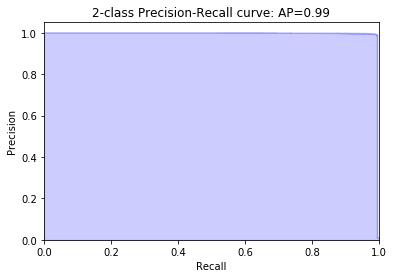

In [76]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

precision, recall, _ = precision_recall_curve(y_true, y_scores)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision_score(y_true, y_scores)))

In [77]:
fp_scores

[0.4818671941757202,
 0.1583639681339264,
 0.20669876039028168,
 0.18917790055274963,
 0.9666973352432251,
 0.5456122756004333,
 0.9165706634521484,
 0.7558491826057434,
 0.13012012839317322,
 0.9947964549064636,
 0.9939680099487305,
 0.9350549578666687,
 0.052719615399837494,
 0.0947028398513794,
 0.1119249239563942,
 0.057645440101623535,
 0.12898656725883484,
 0.8728489875793457,
 0.05294465273618698,
 0.055373720824718475,
 0.06497780978679657,
 0.05738217383623123,
 0.09184030443429947,
 0.0546567365527153,
 0.05642037093639374,
 0.061788856983184814,
 0.08397261798381805,
 0.06811268627643585,
 0.056748680770397186,
 0.7685471177101135,
 0.3165988028049469,
 0.3442709147930145,
 0.4469781816005707,
 0.773203432559967,
 0.24938032031059265,
 0.07144143432378769,
 0.05624231696128845,
 0.05392627418041229,
 0.09005618840456009,
 0.07412471622228622,
 0.08484549075365067,
 0.061797358095645905,
 0.07126377522945404,
 0.06423059105873108,
 0.056282155215740204,
 0.060075342655181885,

In [82]:
from sklearn import metrics

In [90]:
len([s for s in tp_scores if s >= 0.9])

3987

In [92]:
len(tp_scores)

4373